In [1]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

%matplotlib inline
sns.set(rc={'figure.figsize':(15,12)})

In [2]:
df = pd.read_csv('Train_hMYJ020/train.csv')
df.head()

case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0        1              8                  c                   3   
1        2              2                  c                   5   
2        3             10                  e                   1   
3        4             26                  b                   2   
4        5             26                  b                   2   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y                                  2  radiotherapy   

  Ward_Type Ward_Facility_Code  Bed Grade  patientid  City_Code_Patient  \
0         R                  F        2.0      31397                7.0   
1         S                  F        2.0      31397                7.0   
2         S                  E        2.0      31397                7.0   
3         R                  D        2.0      31397                7.0   
4         S                  D        2.0      31397                7.0   

  Type of Admission Severity of Illness  Visitors with Patient    Age  \
0         Emergency             Extreme                      2  51-60   
1            Trauma             Extreme                      2  51-60   
2            Trauma             Extreme                      2  51-60   
3            Trauma             Extreme                      2  51-60   
4            Trauma             Extreme                      2  51-60   

   Admission_Deposit   Stay  
0             4911.0   0-10  
1             5954.0  41-50  
2             4745.0  31-40  
3             7272.0  41-50  
4             5558.0  41-50

In [3]:
df.describe().transpose()

count           mean           std  \
case_id                            318438.0  159219.500000  91925.276847   
Hospital_code                      318438.0      18.318841      8.633755   
City_Code_Hospital                 318438.0       4.771717      3.102535   
Available Extra Rooms in Hospital  318438.0       3.197627      1.168171   
Bed Grade                          318325.0       2.625807      0.873146   
patientid                          318438.0   65747.579472  37979.936440   
City_Code_Patient                  313906.0       7.251859      4.745266   
Visitors with Patient              318438.0       3.284099      1.764061   
Admission_Deposit                  318438.0    4880.749392   1086.776254   

                                      min       25%       50%        75%  \
case_id                               1.0  79610.25  159219.5  238828.75   
Hospital_code                         1.0     11.00      19.0      26.00   
City_Code_Hospital                    1.0      2.00       5.0       7.00   
Available Extra Rooms in Hospital     0.0      2.00       3.0       4.00   
Bed Grade                             1.0      2.00       3.0       3.00   
patientid                             1.0  32847.00   65724.5   98470.00   
City_Code_Patient                     1.0      4.00       8.0       8.00   
Visitors with Patient                 0.0      2.00       3.0       4.00   
Admission_Deposit                  1800.0   4186.00    4741.0    5409.00   

                                        max  
case_id                            318438.0  
Hospital_code                          32.0  
City_Code_Hospital                     13.0  
Available Extra Rooms in Hospital      24.0  
Bed Grade                               4.0  
patientid                          131624.0  
City_Code_Patient                      38.0  
Visitors with Patient                  32.0  
Admission_Deposit                   11008.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [5]:
df.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [6]:
relValue = {
    '0-10':0,
    '11-20':1,
    '21-30':2,
    '31-40':3,
    '41-50':4,
    '51-60':5,
    '61-70':6,
    '71-80':7,
    '81-90':8,
    '91-100':9,
    'More than 100 Days':10
}

df["Stay"] = df['Stay'].map(relValue).astype(int)

In [7]:
df["Bed Grade"].median()

3.0

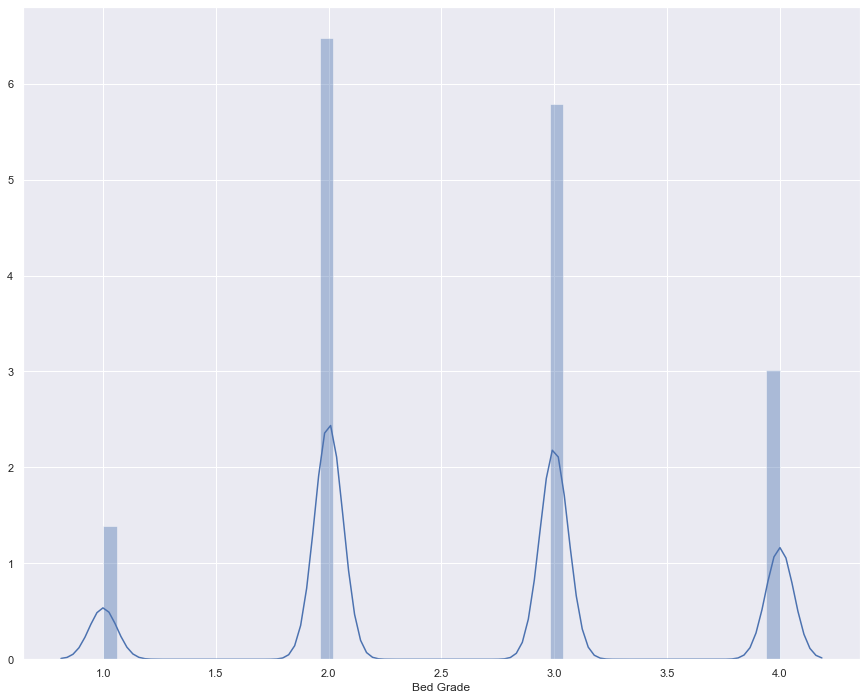

In [8]:
sns.distplot(df["Bed Grade"])

In [9]:
df["Bed Grade"].skew()

0.05175434072073738

In [10]:
np.unique(df['Bed Grade'], return_counts=True)

(array([ 1.,  2.,  3.,  4., nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([ 26505, 123671, 110583,  57566,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      

In [11]:
df['Bed Grade'] = df['Bed Grade'].fillna(df['Bed Grade'].median())

In [12]:
df["Bed Grade"].isna().sum()

0

In [13]:
df["City_Code_Patient"].skew()

1.5817362427825918

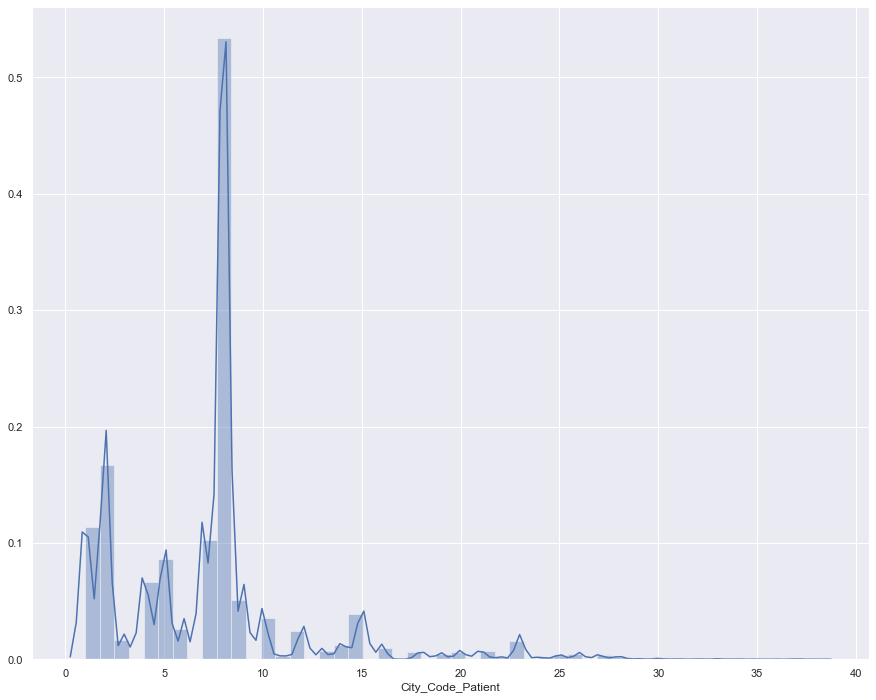

In [14]:
sns.distplot(df["City_Code_Patient"])

In [15]:
df['City_Code_Patient'].median()

8.0

In [16]:
df["City_Code_Patient"].shape

(318438,)

In [17]:
df["City_Code_Patient"].fillna(0.0, inplace=True)

In [18]:
df['City_Code_Patient'].isna().sum()

0

In [19]:
np.unique(df['City_Code_Patient'], return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.]),
 array([  4532,  26377,  38869,   3772,  15380,  20079,   6005,  23807,
        124011,  11795,   8174,    658,   5647,   1625,   2927,   8950,
          2254,   1404,   1028,   1409,   1602,    405,   3698,    360,
           798,   1023,    771,    521,     98,    133,     59,     52,
            78,     46,     16,     12,     57,      6]))

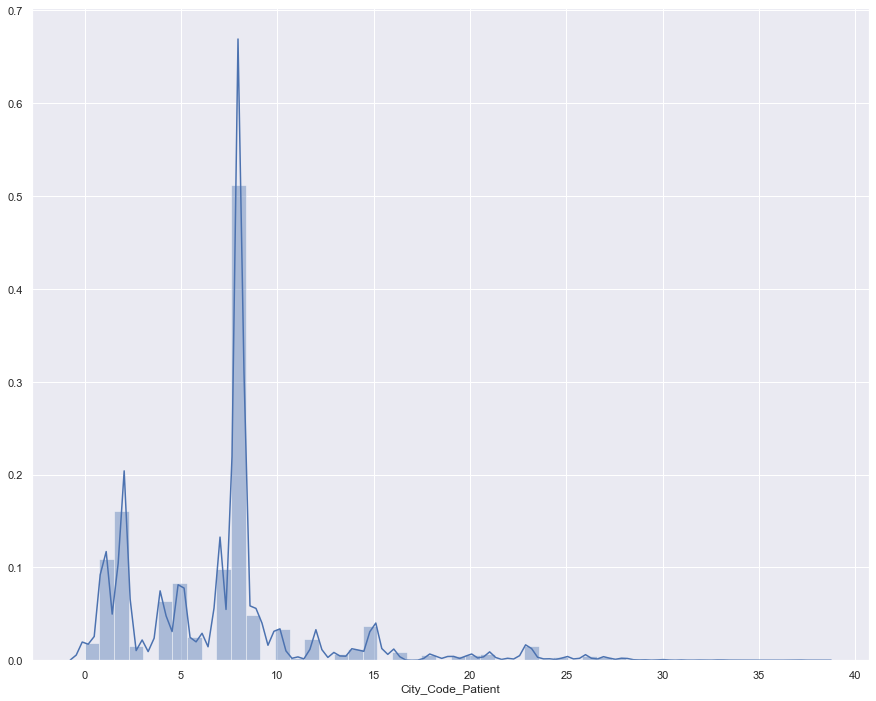

In [20]:
sns.distplot(df["City_Code_Patient"])

In [21]:
### Defining a function which will eliminate highly correlated columns and
### draw the heat map of the correlation matrix
def eliminate_corr_columns(df, threshold):
    corr_matrix = X.corr().abs()
    sns.heatmap(corr_matrix)
    upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > threshold)]
    df_new = df.drop(to_drop, axis=1)
    return df_new

In [22]:
categorical_columns = list(df.select_dtypes(['object']).columns)
categorical_columns

['Hospital_type_code',
 'Hospital_region_code',
 'Department',
 'Ward_Type',
 'Ward_Facility_Code',
 'Type of Admission',
 'Severity of Illness',
 'Age']

In [23]:
new_df = df
for column in ['Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness']:
    expanded_df = pd.get_dummies(df[column], drop_first=False)
    new_df = pd.concat([new_df, expanded_df], axis=1).drop(column, axis=1)

In [24]:
new_df.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Bed Grade', 'patientid', 'City_Code_Patient', 'Visitors with Patient',
       'Age', 'Admission_Deposit', 'Stay', 'TB & Chest disease', 'anesthesia',
       'gynecology', 'radiotherapy', 'surgery', 'P', 'Q', 'R', 'S', 'T', 'U',
       'A', 'B', 'C', 'D', 'E', 'F', 'Emergency', 'Trauma', 'Urgent',
       'Extreme', 'Minor', 'Moderate'],
      dtype='object')

In [25]:
new_df.shape

(318438, 36)

In [26]:
list(new_df.select_dtypes(['object']).columns)

['Hospital_type_code', 'Hospital_region_code', 'Age']

In [27]:
np.unique(df['Age'], return_counts=True)

(array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
        '71-80', '81-90', '91-100'], dtype=object),
 array([ 6254, 16768, 40843, 63639, 63749, 48514, 33687, 35792,  7890,
         1302]))

In [28]:
relValue = {
    'a':0,
    'b':1,
    'c':2,
    'd':3,
    'e':4,
    'f':5,
    'g':6
}
new_df["Hospital_type_code"] = new_df['Hospital_type_code'].map(relValue).astype(int)

In [29]:
relValue = {
    'X':0,
    'Y':1,
    'Z':2,
}
new_df["Hospital_region_code"] = new_df['Hospital_region_code'].map(relValue).astype(int)

In [30]:
# relValue = {
#     'TB & Chest disease':0,
#     'anesthesia':1,
#     'gynecology':2,
#     'radiotherapy':3,
#     'surgery':4
# }
# new_df["Department"] = new_df['Department'].map(relValue).astype(int)

In [31]:
relValue = {
    '0-10':0,
    '11-20':1,
    '21-30':2,
    '31-40':3,
    '41-50':4,
    '51-60':5,
    '61-70':6,
    '71-80':7,
    '81-90':8,
    '91-100':9,
}

new_df["Age"] = new_df['Age'].map(relValue).astype(int)

In [32]:
new_df.head().transpose()

0        1        2        3        4
case_id                                1.0      2.0      3.0      4.0      5.0
Hospital_code                          8.0      2.0     10.0     26.0     26.0
Hospital_type_code                     2.0      2.0      4.0      1.0      1.0
City_Code_Hospital                     3.0      5.0      1.0      2.0      2.0
Hospital_region_code                   2.0      2.0      0.0      1.0      1.0
Available Extra Rooms in Hospital      3.0      2.0      2.0      2.0      2.0
Bed Grade                              2.0      2.0      2.0      2.0      2.0
patientid                          31397.0  31397.0  31397.0  31397.0  31397.0
City_Code_Patient                      7.0      7.0      7.0      7.0      7.0
Visitors with Patient                  2.0      2.0      2.0      2.0      2.0
Age                                    5.0      5.0      5.0      5.0      5.0
Admission_Deposit                   4911.0   5954.0   4745.0   7272.0   5558.0
Stay                                   0.0      4.0      3.0      4.0      4.0
TB & Chest disease                     0.0      0.0      0.0      0.0      0.0
anesthesia                             0.0      0.0      1.0      0.0      0.0
gynecology                             0.0      0.0      0.0      0.0      0.0
radiotherapy                           1.0      1.0      0.0      1.0      1.0
surgery                                0.0      0.0      0.0      0.0      0.0
P                                      0.0      0.0      0.0      0.0      0.0
Q                                      0.0      0.0      0.0      0.0      0.0
R                                      1.0      0.0      0.0      1.0      0.0
S                                      0.0      1.0      1.0      0.0      1.0
T                                      0.0      0.0      0.0      0.0      0.0
U                                      0.0      0.0      0.0      0.0      0.0
A                                      0.0      0.0      0.0      0.0      0.0
B                                      0.0      0.0      0.0      0.0      0.0
C                                      0.0      0.0      0.0      0.0      0.0
D                                      0.0      0.0      0.0      1.0      1.0
E                                      0.0      0.0      1.0      0.0      0.0
F                                      1.0      1.0      0.0      0.0      0.0
Emergency                              1.0      0.0      0.0      0.0      0.0
Trauma                                 0.0      1.0      1.0      1.0      1.0
Urgent                                 0.0      0.0      0.0      0.0      0.0
Extreme                                1.0      1.0      1.0      1.0      1.0
Minor                                  0.0      0.0      0.0      0.0      0.0
Moderate                               0.0      0.0      0.0      0.0      0.0

In [33]:
df_corr = new_df.corr()

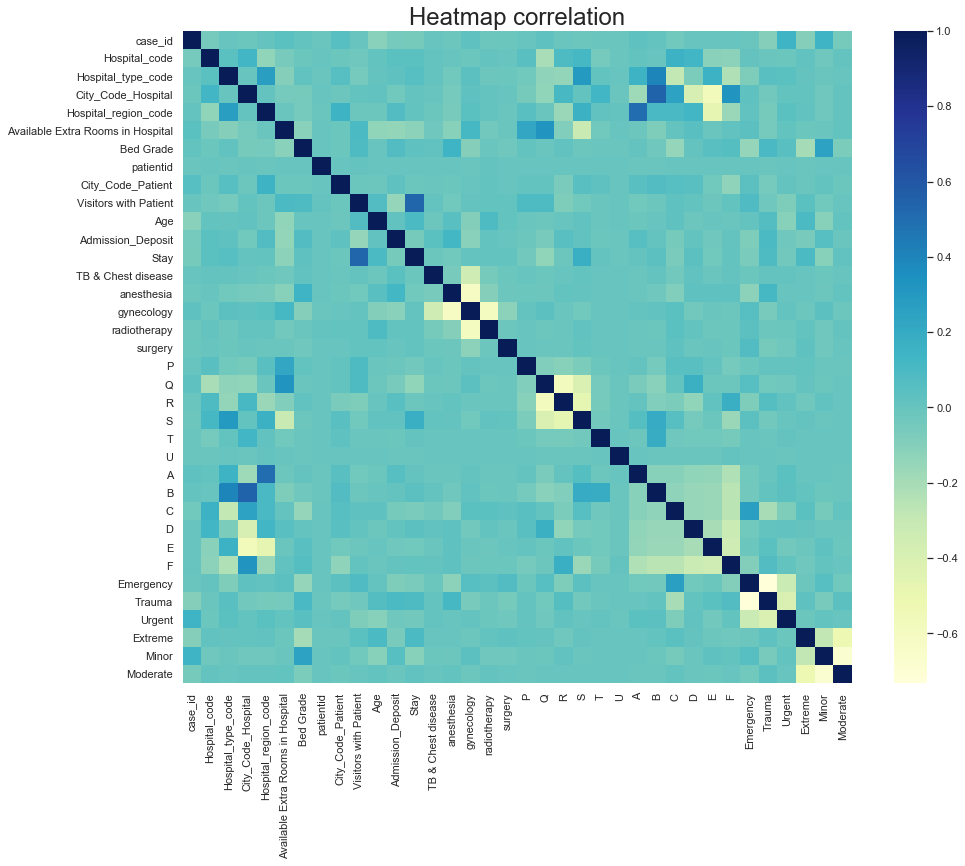

In [34]:
sns.heatmap(df_corr, cmap='YlGnBu')
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

In [35]:
X = new_df.drop('Stay', axis=1)
y = new_df['Stay']

case_id  Hospital_code  Hospital_type_code  City_Code_Hospital  \
0        1              8                   2                   3   
1        2              2                   2                   5   
2        3             10                   4                   1   
3        4             26                   1                   2   
4        5             26                   1                   2   

   Hospital_region_code  Available Extra Rooms in Hospital  Bed Grade  \
0                     2                                  3        2.0   
1                     2                                  2        2.0   
2                     0                                  2        2.0   
3                     1                                  2        2.0   
4                     1                                  2        2.0   

   patientid  City_Code_Patient  Visitors with Patient  ...  A  B  C  D  E  F  \
0      31397                7.0                      2  ...  0  0  0  0  0  1   
1      31397                7.0                      2  ...  0  0  0  0  0  1   
2      31397                7.0                      2  ...  0  0  0  0  1  0   
3      31397                7.0                      2  ...  0  0  0  1  0  0   
4      31397                7.0                      2  ...  0  0  0  1  0  0   

   Emergency  Urgent  Extreme  Minor  
0          1       0        1      0  
1          0       0        1      0  
2          0       0        1      0  
3          0       0        1      0  
4          0       0        1      0  

[5 rows x 32 columns]

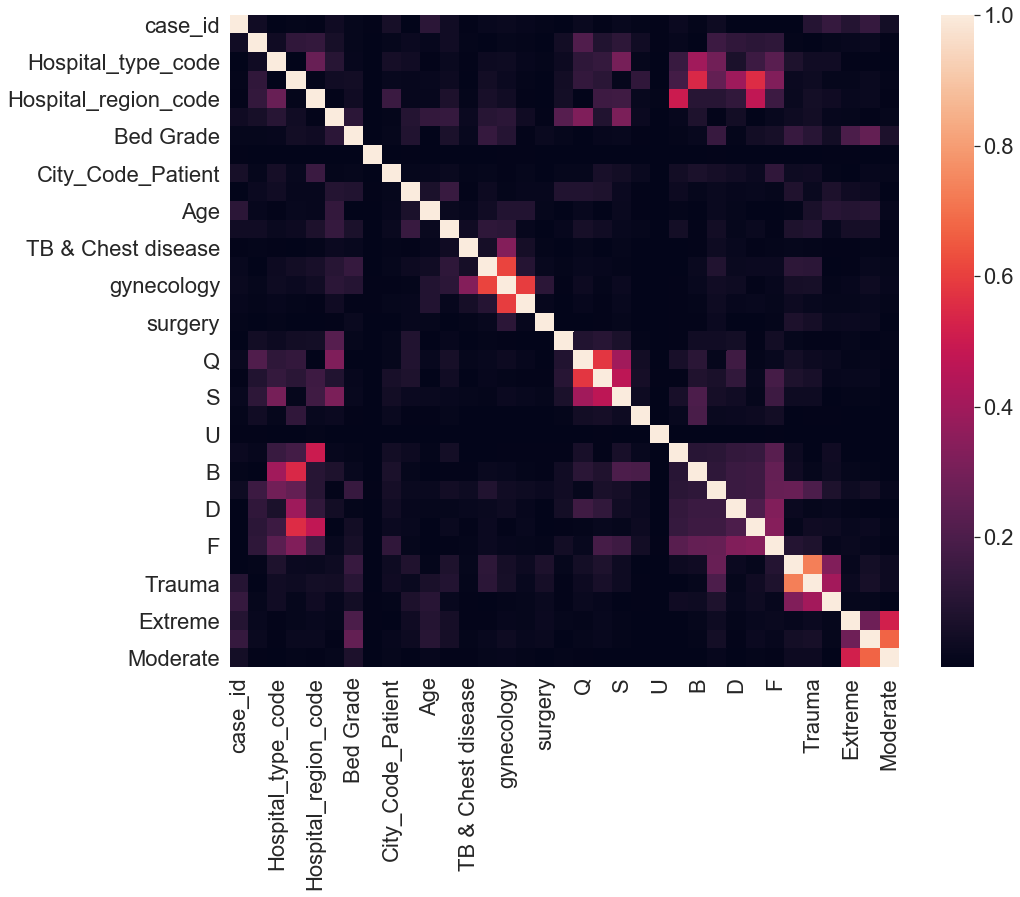

In [36]:
X = eliminate_corr_columns(X, 0.6)
X.head()

In [37]:
X.shape

(318438, 32)

In [38]:
X.drop(['case_id', 'patientid','Hospital_type_code', 'Hospital_region_code'], axis=1, inplace=True)

In [39]:
X.shape

(318438, 28)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(254750, 28)
(63688, 28)
(254750,)
(63688,)


In [42]:
X_train.isna().sum()

Hospital_code                        0
City_Code_Hospital                   0
Available Extra Rooms in Hospital    0
Bed Grade                            0
City_Code_Patient                    0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
TB & Chest disease                   0
anesthesia                           0
radiotherapy                         0
surgery                              0
P                                    0
Q                                    0
R                                    0
S                                    0
T                                    0
U                                    0
A                                    0
B                                    0
C                                    0
D                                    0
E                                    0
F                                    0
Emergency                            0
Urgent                   

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [45]:
# from sklearn.neighbors import KNeighborsClassifier

In [46]:
# #Setup arrays to store training and test accuracies
# neighbors = np.arange(1,20)
# train_accuracy =np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))

# min_max_scaler = MinMaxScaler()

# for i,k in enumerate(neighbors):
#     #Setup a knn classifier with k neighbors
#     knn = KNeighborsClassifier(n_neighbors=k)
    
#     #Scaling and fitting the MinMaxScaller
#     X_train = min_max_scaler.fit_transform(X_train)
    
#     #Fit the model
#     knn.fit(X_train, y_train)
    
#     #Compute accuracy on the training set
#     train_accuracy[i] = knn.score(X_train, y_train)
#     #print("Training accuracy for",i,"is", train_accuracy[i])
    
#     X_test = min_max_scaler.transform(X_test)
    
#     #Compute accuracy on the test set
#     test_accuracy[i] = knn.score(X_test, y_test) 
#     test_accuracy[i]
#     print("Accuracy for",i+1,"is", test_accuracy[i])

In [47]:
# Import the library and build the model using that, the C variable is tuned for best result
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1, probability=False, random_state=42)
model.fit(X_train_scaled, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [48]:
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)

In [49]:
# Get the Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.38979085542017333

In [ ]:
# classifier_b = SVC(C=10, kernel='linear',class_weight={0:0.60, 1:0.40})
# classifier_b.fit(X_train_scaled, y_train)
# prediction_SVM_b_all = classifier_b.predict(X_test_scaled)
# accuracy_score(y_test, prediction_SVM_b_all)

In [ ]:
# classifier_c = SVC(C=0.01, kernel='sigmoid',class_weight={0:0.60, 1:0.40})
# classifier_c.fit(X_train_scaled, y_train)
# prediction_SVM_c_all = classifier_c.predict(X_test_scaled)
# accuracy_score(y_test, prediction_SVM_c_all)

In [ ]:
pip3 install xgboost